In [1]:
import numpy as np
import torch as T
import torch.nn as nn
from matplotlib import pyplot as plt
import json
import rasterio
from copy import deepcopy
import rasterio.features
import os
import glob
import geopandas as gpd
from tqdm.auto import tqdm, trange
import scipy.stats
from shapely import geometry as shpg
from datetime import datetime
import pandas as pd
from rasterio.features import rasterize
from shapely import wkt

# gpd.io.file.fiona.drvsupport.supported_drivers["LIBKML"] = "rw"

from fiona.drvsupport import supported_drivers
supported_drivers['LIBKML'] = 'rw'

print(T.cuda.is_available() )
device = T.device("cuda") if T.cuda.is_available() else T.device("cpu")

True


In [2]:
# base_dir = '/home/kolya/data/gediwa/'
base_dir = "./data/gediwa/"

In [3]:
def read_data(filepath: str, *args, **kwargs):
    with rasterio.open(filepath) as src:
        return src.read(*args, **kwargs)

def transparent_cmap(cmap, max_alpha=0.8, N=255):
    "Copy colormap and set alpha values"
    mycmap = deepcopy(cmap)
    mycmap._init()
    mycmap._lut[:, -1] = np.linspace(0, max_alpha, N + 4)
    return mycmap

def s2_to_img(ar, rgb_idx=[0, 1, 2]):
    """
    Normalize Sentinel-2 RGB channels for display
    """
    return (ar[rgb_idx]).clip(0, 3000).transpose((1, 2, 0)) / 3000

# Get data with workflow

In [4]:
from vibe_core.client import get_default_vibe_client
client = get_default_vibe_client()

In [5]:
# Region in Spain
geom = wkt.loads('POLYGON ((-3.0002304797999999 38.8489984834000026, -1.7350398852000000 38.8421486724000005, -1.7521345912999999 37.8528295029000006, -3.0002273641000001 37.8594419588999997, -3.0002304797999999 38.8489984834000026))')
# Total time range: year of 2021
time_range = (datetime(2021, 1, 1), datetime(2022, 1, 1))
# Time ranges where we'll download Sentinel-2 data
# time_ranges = [(datetime(2021, m, 1), datetime(2021, m + 1, 1)) for m in (3, 7, 10)]
time_ranges = [(datetime(2021, 3, 14), datetime(2021, 3, 14)), (datetime(2021, 7, 12), datetime(2021, 7, 12)), (datetime(2021, 10, 5), datetime(2021, 10, 5))]

In [6]:
# Download GEDI data for the whole of 2021
gedi_run = client.run("data_ingestion/gedi/download_gedi_rh100", "test GEDI", geometry=geom, time_range=time_range)
gedi_run.monitor()
# Read and merge data from each product
dfs = [gpd.read_file(i.assets[0].local_path) for i in gedi_run.output["rh100"] if i.assets]
merge_df = pd.concat(dfs)
# Plot available points colored by beam
merge_df.plot("beam", markersize=1)
plt.show()

ConnectionError: HTTPConnectionPool(host='172.18.0.3', port=30000): Max retries exceeded with url: /v0/runs (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7f78870be400>: Failed to establish a new connection: [Errno 111] Connection refused'))

In [7]:
#client.describe_run(gedi_run.id).task_details
for i in gedi_run.output["rh100"]:
    if i.assets:
        print(i.assets[0].local_path)

/home/yingzhen/.cache/farmvibes-ai/data/assets/4dc8803b-bb01-42b2-a3cc-c52e99d8e9d3/4dc8803b-bb01-42b2-a3cc-c52e99d8e9d3.gpkg
/home/yingzhen/.cache/farmvibes-ai/data/assets/9f4a1266-be9c-4f8f-8b0c-25971943838e/9f4a1266-be9c-4f8f-8b0c-25971943838e.gpkg
/home/yingzhen/.cache/farmvibes-ai/data/assets/9e90751f-52f7-4d81-b434-6bfc14bfb785/9e90751f-52f7-4d81-b434-6bfc14bfb785.gpkg
/home/yingzhen/.cache/farmvibes-ai/data/assets/86400c8e-31cc-4a10-bb5f-8a17de3fd992/86400c8e-31cc-4a10-bb5f-8a17de3fd992.gpkg
/home/yingzhen/.cache/farmvibes-ai/data/assets/e34aa8ec-823a-44eb-839c-338dc62c1714/e34aa8ec-823a-44eb-839c-338dc62c1714.gpkg
/home/yingzhen/.cache/farmvibes-ai/data/assets/01407c2d-a345-42dd-85fb-3d36336d9ce3/01407c2d-a345-42dd-85fb-3d36336d9ce3.gpkg
/home/yingzhen/.cache/farmvibes-ai/data/assets/9835d855-a989-4e6d-be11-6eb31b500798/9835d855-a989-4e6d-be11-6eb31b500798.gpkg
/home/yingzhen/.cache/farmvibes-ai/data/assets/77ebd52f-1ef6-4fc3-b2a5-af77d88031e9/77ebd52f-1ef6-4fc3-b2a5-af77d88031

In [8]:
# Download Sentinel2- imagery + cloud masks
# Use smaller time ranges to avoid downloading the whole year's worth of data
# We're downloading one month at a time to select a relatively cloud-free image
s2_runs = [
    client.run(
        "data_ingestion/sentinel2/preprocess_s2_improved_masks",
        f"Spain 2021-{tr[0].month:02d}",
        geometry=geom,
        time_range=tr,
        parameters={"max_tiles_per_time": 1}
    )
    for tr in time_ranges
]
# We'll monitor the first one until it's done, but all runs are running simultaneously
# We call monitor here for all runs to make sure it blocks until we have all the data
for run in s2_runs:
    run.monitor()

Output()

Output()

Output()

(1000, 1000, 3)


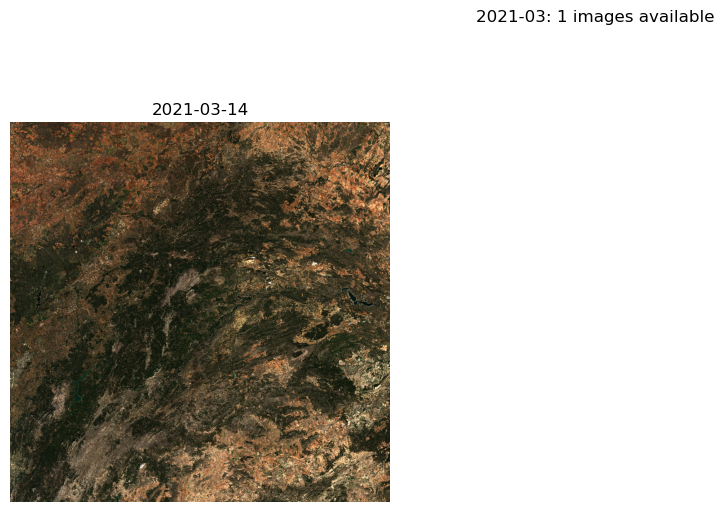

(1000, 1000, 3)


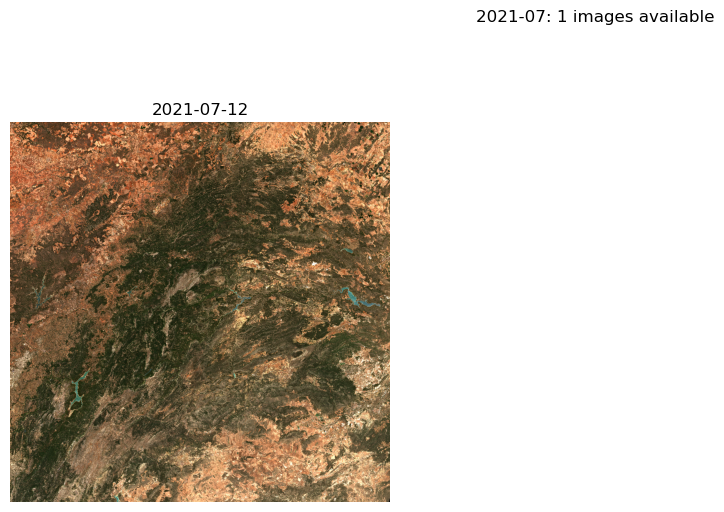

(1000, 1000, 3)


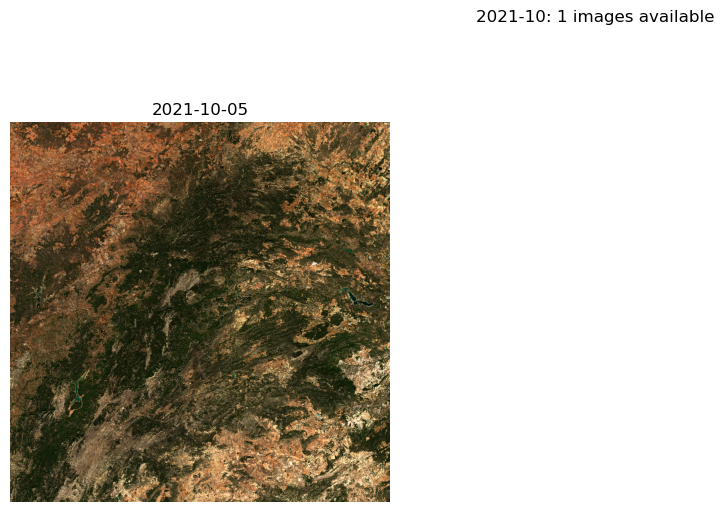

In [9]:
# Plot some images
for run in s2_runs:
    plt.figure(figsize=(12, 6))
    s2_rasters = sorted(run.output["raster"], key=lambda x: x.time_range[0])
    # Plot 3 rasers for each time range
    for i, r in enumerate(s2_rasters[:3], start=1):
        ar = s2_to_img(read_data(r.raster_asset.url, indexes=(4, 3, 2), out_shape=(1000, 1000)))
        print(ar.shape)
        plt.subplot(1, 3, i)
        plt.imshow(ar)
        plt.title(r.time_range[0].strftime("%Y-%m-%d"))
        plt.axis("off")
    m = s2_rasters[0].time_range[0].strftime("%Y-%m")
    plt.suptitle(f"{m}: {len(run.output['raster'])} images available")
    plt.tight_layout()
    plt.show()

In [10]:
selected_idx = []
selected_cover = []
MAX_COVER = .05
for run in tqdm(s2_runs):
    # Compute cloud cover for each available date
    cloud_cover = [read_data(r.raster_asset.url).mean() for r in run.output["mask"]]
    least_cover_idx = np.argmin(cloud_cover)
    least_cover = cloud_cover[least_cover_idx]
    if least_cover > MAX_COVER:
        raise ValueError(f"Could not find product with less than {MAX_COVER:.2%} cloud cover. Minimum cover was {least_cover:.2%}")
    selected_idx.append(least_cover_idx)
    selected_cover.append(least_cover)

  0%|          | 0/3 [00:00<?, ?it/s]

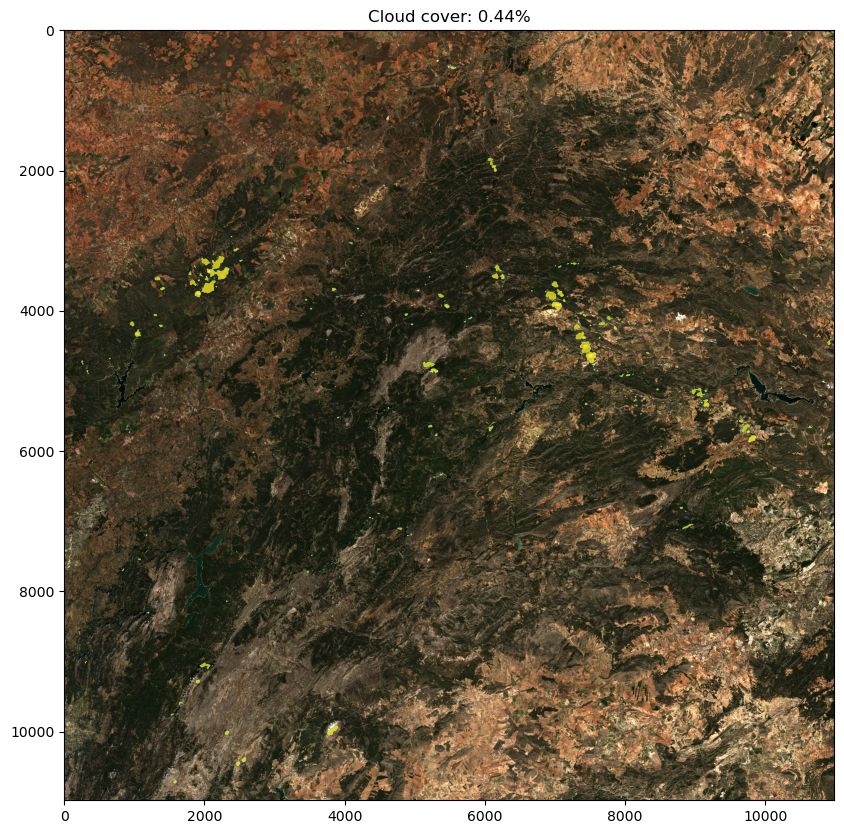

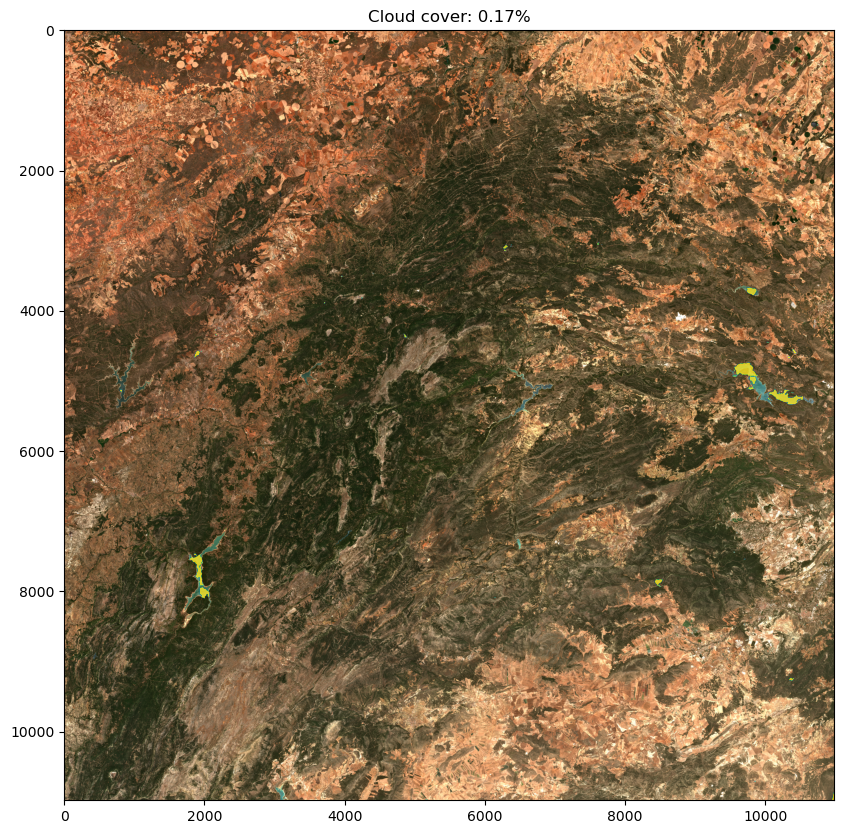

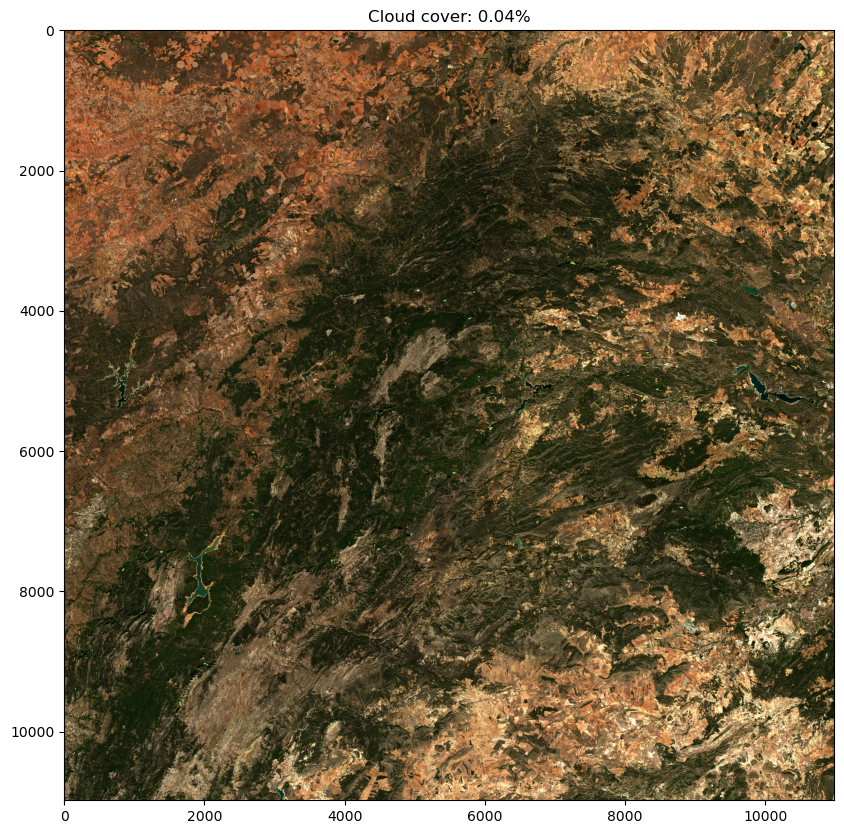

In [11]:
for i, run in zip(selected_idx, s2_runs):
    s2_ar = s2_to_img(read_data(run.output["raster"][i].raster_asset.url, indexes=[4, 3, 2]))
    cloud_ar = read_data(run.output["mask"][i].raster_asset.url)
    plt.figure(figsize=(10, 10))
    plt.imshow(s2_ar)
    plt.imshow(cloud_ar[0], cmap=transparent_cmap(plt.cm.viridis))
    plt.title(f"Cloud cover: {cloud_ar.mean():.2%}")
    plt.show()

In [12]:
# Manual selection
# selected_idx = [2, 1, 0]

selected_s2 = [run.output["raster"][i] for idx, run in zip(selected_idx, s2_runs)]

In [13]:
print(selected_idx)

[0, 0, 0]


In [14]:
with rasterio.open(selected_s2[0].raster_asset.url) as src:
    transform = src.transform
    height, width = src.height, src.width
    crs = src.crs
    num_bands = src.count

all_heights = rasterize([(r["geometry"], r["rh100"]) for _, r in merge_df.to_crs(crs).iterrows()], out_shape=(height, width), transform=transform, fill=-1, dtype=np.float32)[None]
mask = all_heights[0] != -1

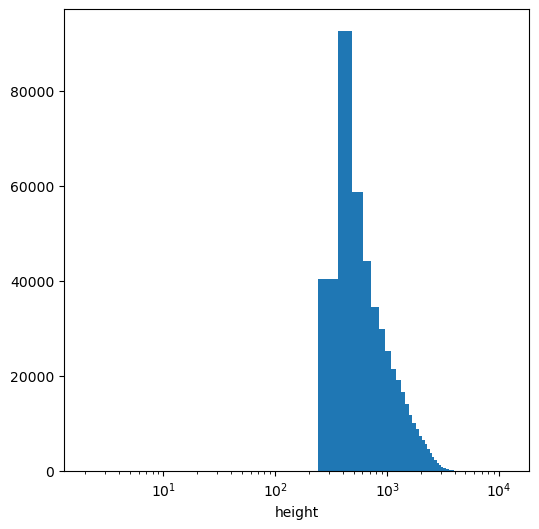

In [15]:
plt.figure(figsize=(6,6))
plt.xscale('log')
plt.xlabel('height')
plt.hist(all_heights[0][mask], bins=100)
plt.show()

In [16]:
# Load images in memory and stack all bands as channels
sentinels = np.zeros((num_bands * len(selected_s2), height, width)).astype(np.float32)
for i, r in enumerate(tqdm(selected_s2)):
    # Read data and normalize by quantification value
    sentinels[num_bands*i:num_bands*(i+1)] = read_data(r.raster_asset.url).astype(np.float32) / 10000

  0%|          | 0/3 [00:00<?, ?it/s]

In [17]:
sentinels = sentinels[:12,:,:]

In [18]:
sentinels.shape

(12, 10980, 10980)

In [19]:
print(num_bands)

12


# Training a small CNN on Sentinel -> GEDI
(For local analysis, a small CNN (receptive field of 50x50m at 10m resolution) performs better than models trained on the highe-resolution NAIP imagery.)

In [20]:
device = T.device("cpu")

In [21]:
print( sentinels.shape[0])

12


In [22]:
def train_model(checker_width):

    # target for Sentinel
    all_heights_small = all_heights
    
    all_heights_small_train = np.copy(all_heights_small)
    all_heights_small_test = np.copy(all_heights_small)
    
    sentinels_cuda = T.from_numpy(sentinels).to(device)    
    
    for i in range(all_heights_small.shape[1] // checker_width + 1):
        for j in range(all_heights_small.shape[2] // checker_width + 1):
            if (i+j)%2 == 0:
                all_heights_small_train[:, i*checker_width:(i+1)*checker_width, j*checker_width:(j+1)*checker_width] = -1
            else:
                all_heights_small_test[:, i*checker_width:(i+1)*checker_width, j*checker_width:(j+1)*checker_width] = -1
    
    all_heights_small_train = T.from_numpy(all_heights_small_train[0]).log().to(device)
    all_heights_small_test = T.from_numpy(all_heights_small_test[0]).log().to(device)
    
    model = T.nn.Sequential(T.nn.Conv2d(sentinels.shape[0],64,3,1,1), T.nn.ELU(), T.nn.Conv2d(64,1,3,1,1)).to(device)
    # torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0)
    opt = T.optim.Adam(model.parameters(), 0.003)
    print(sum(p.numel() for p in model.parameters()))
    
    reconstruction = np.zeros_like(all_heights_small[0]) - 1

    rf = 2

    log = []

    bs = 64
    side = 64

    for it in trange(10000):

        opt.zero_grad()

        batch = T.zeros(bs, sentinels.shape[0], side,side).to(device)
        # 64 x 36 x 64 x 64 ->
        target = T.zeros(bs, side, side).to(device)
        coords = []
        
        for i in range(bs):
            x = np.random.randint(all_heights_small.shape[1]-side+1)
            y = np.random.randint(all_heights_small.shape[2]-side+1)
            batch[i] = sentinels_cuda[:,x:x+side,y:y+side]
            target[i] = all_heights_small_train[x:x+side,y:y+side]
            coords.append((x,y))

        target = target[..., rf:-rf, rf:-rf]

        outs = model(batch).squeeze(1)
        loss = ( (outs[..., rf:-rf, rf:-rf][~T.isnan(target)] - target[~T.isnan(target)])**2 ).mean()

        loss.backward()
        
        train_loss = loss.item()

        opt.step()
        
        for i,(x,y),o in zip(range(bs),coords,outs.detach().cpu().numpy()):
            reconstruction[x+rf:x+side-rf, y+rf:y+side-rf] = o[..., rf:-rf, rf:-rf]
        
        with T.no_grad():
            
            target = T.zeros(bs, side, side).to(device)
            coords = []
            
            for i in range(bs):
                x = np.random.randint(all_heights_small.shape[1]-side+1)
                y = np.random.randint(all_heights_small.shape[2]-side+1)
                batch[i] = sentinels_cuda[:, x:x+side, y:y+side]
                target[i] = all_heights_small_test[x:x+side, y:y+side]
                coords.append((x,y))

            target = target[..., rf:-rf, rf:-rf]

            outs = model(batch).squeeze(1)
            loss = ( (outs[..., rf:-rf, rf:-rf][~T.isnan(target)] - target[~T.isnan(target)])**2 ).mean()
            
            test_loss = loss.item()
            
            for i,(x,y),o in zip(range(bs),coords,outs.detach().cpu().numpy()):
                reconstruction[x+rf:x+side-rf, y+rf:y+side-rf] = o[..., rf:-rf, rf:-rf]

        log.append((train_loss, test_loss))

        if (it+1)%1000 == 0:
            print(it, np.array(log[-1000:]).mean(0), (reconstruction!=-1).mean())
            
    return model, log, reconstruction

In [23]:
models = []
logs = []
reconstructions = []
# widths = [1, 2, 4, 8, 16, 32, 64, 128, 256, 512]
widths = [32]
for checker_width in widths:
    print(checker_width)
    model, log, reconstruction = train_model(checker_width)
    models.append(model)
    logs.append(log)
    reconstructions.append(reconstruction)

32
7553


  0%|          | 0/10000 [00:00<?, ?it/s]

999 [0.64604063 0.61796716] 0.9733883016313815
1999 [0.1764675  0.17672423] 0.9961717446192946
2999 [0.16855077 0.1696995 ] 0.9974998009296585
3999 [0.16750188 0.16847711] 0.9980317168821603
4999 [0.16305222 0.16520563] 0.9982728325387109
5999 [0.16360968 0.16467196] 0.9984739848242044
6999 [0.16035308 0.16367296] 0.9986222341664427
7999 [0.16013178 0.16127158] 0.9987185676225361
8999 [0.15845247 0.16022038] 0.9987841115324767
9999 [0.15942674 0.16113277] 0.9988472251253314


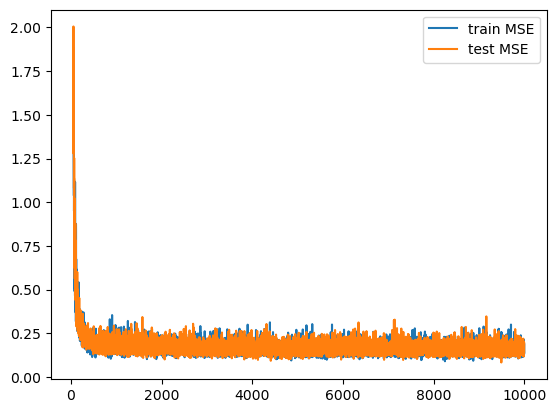

In [24]:
# errors = np.array(logs)[:,-1000:].mean(1)
# pt.plot(widths, errors[:,0], label='train MSE')
# pt.plot(widths, errors[:,1], label='test MSE')
# pt.xscale('log')
# pt.xlabel('checker width')
# pt.legend()
# pt.show()
errors = np.array(logs[0])
skip = 50
its = np.arange(errors.shape[0])[skip:]
plt.plot(its, errors[skip:, 0], label="train MSE")
plt.plot(its, errors[skip:, 1], label="test MSE")
plt.legend("Iterations")
plt.legend()
plt.show()

In [25]:
len(widths)

1

In [27]:
reconstructions[0].min()

-1.0

In [ ]:
plt.figure(figsize=(5 * (len(widths) + 1), 5))
plt.subplot(1,len(widths)+1,1)
plt.imshow(sentinels[[3, 2, 1]].transpose((1, 2, 0)).clip(0, .3) / .3)
for i,w in enumerate(widths):
    plt.subplot(1,len(widths)+1,i+2)
    plt.imshow(reconstructions[i], cmap='Greens', vmin=5,vmax=9)
plt.show()

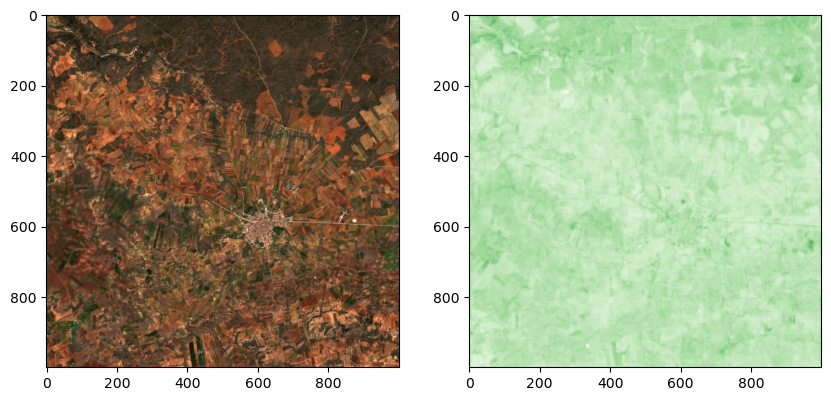

In [31]:
plt.figure(figsize=(5 * (len(widths) + 1), 5))
plt.subplot(1,len(widths)+1,1)
plt.imshow(sentinels[[3, 2, 1]][:, 500:1500, 500:1500].transpose((1, 2, 0)).clip(0, .3) / .3)
for i,w in enumerate(widths):
    plt.subplot(1,len(widths)+1,i+2)
    plt.imshow(reconstructions[i][500:1500, 500:1500], cmap='Greens', vmin=5,vmax=9)
plt.show()

In [35]:
pred = reconstructions[i][500:1500, 500:1500]
print(np.max(pred))
print(np.min(pred))
print(np.mean(pred))

7.44336
4.0105357
6.1671467


In [38]:
gt = all_heights[0,500:1500, 500:1500]
id_gt = np.where(gt!=-1)
gt_value = gt[id_gt]
gt_value = np.log(gt_value)
print(np.max(gt_value))
print(np.min(gt_value))
print(np.mean(gt_value))

8.048149
5.7004437
6.093715


In [39]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(gt_value, pred[id_gt])
print(id_gt[0].shape)
print(mse)

(6307,)
0.09882059


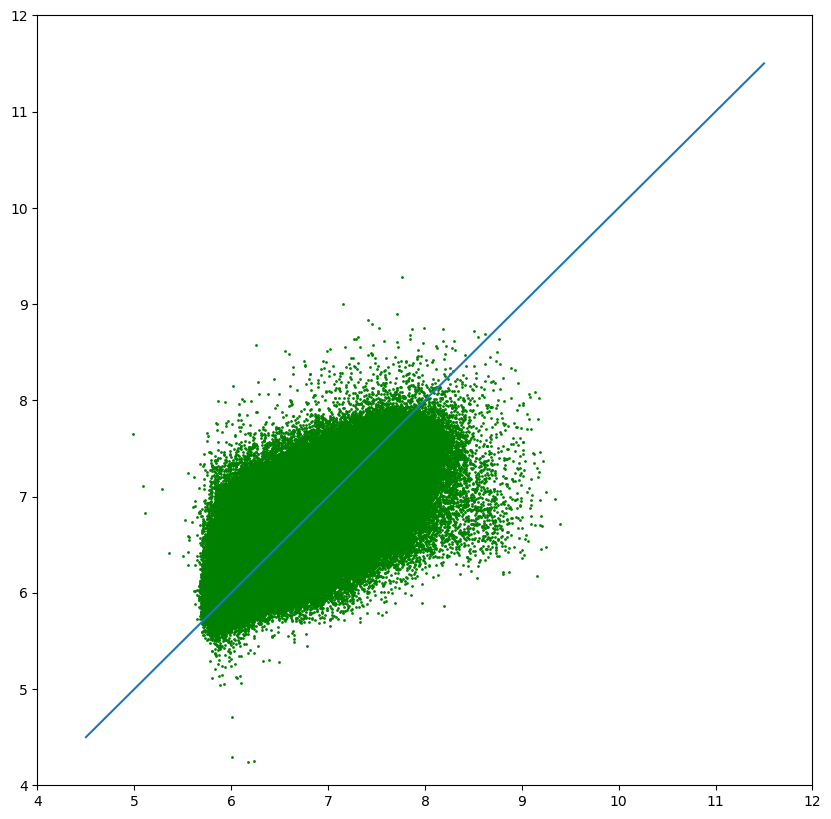

SignificanceResult(statistic=0.7979663265940312, pvalue=0.0)


In [36]:
# for i in [0,-2]:
for i in [0]:
    plt.figure(figsize=(10,10))
    plt.scatter(np.log(all_heights[0][mask]), reconstructions[i][mask], s=1, c='green')
    plt.xlim(4,12)
    plt.ylim(4,12)
    plt.plot([4.5,11.5],[4.5,11.5])
    plt.show()
    print(scipy.stats.spearmanr(np.log(all_heights[0][mask]), reconstructions[i][mask]))

Correlation improves to 0.86 when overfitting with a larger model, and to 0.93 (RMSE in log-height <0.4) when using positional information as input (spatial ensemble).